In [86]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [87]:
sns.set_style("white")
test_ratio = 0.0
data_step = 0.005
data_sigma1 = 2
data_sigma2 = 1
def func(x):
    return np.power(x, 3)

num_data = 20

data_x = np.random.uniform(-4, 4, size=num_data)
data_y = np.zeros(num_data)

num_data_true = 1000
data_x_true = np.linspace(-6, 6, num_data_true)
data_y_true = np.zeros(num_data_true)

In [88]:
for i in range(num_data):
    if (data_x[i] < 0):  # -3 <= x <0, sigma=2 (has more uncertainty inherently)
        data_y[i] = func(data_x[i]) + np.random.normal(0, 3)
    else:  # x>0, sigma=1 (less noisy measurement)
        data_y[i] = func(data_x[i]) + np.random.normal(0, 9)
        
for i in range(num_data_true):
    data_y_true[i] = func(data_x_true[i])

In [89]:
num_train_data = int(num_data * (1 - test_ratio))
num_test_data  = num_data - num_train_data

data_x = np.reshape(data_x, [num_data, 1])
data_y = np.reshape(data_y, [num_data, 1])
data_y_true = np.reshape(data_y_true, [num_data_true, 1])
data_x_true = np.reshape(data_x_true, [num_data_true, 1])

train_x = data_x[:num_train_data, :]
train_y = data_y[:num_train_data, :]
test_x  = data_x[num_train_data:, :]
test_y  = data_y[num_train_data:, :]

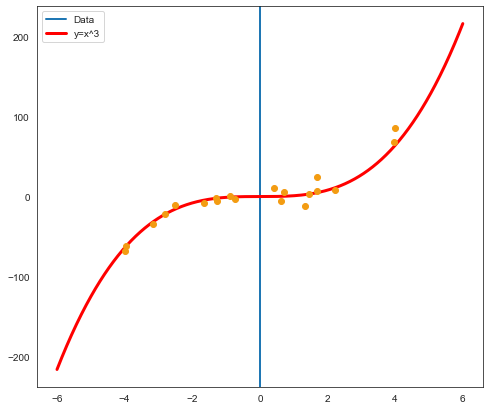

In [90]:
plt.rcParams['figure.figsize'] = [8, 7]
plt.axvline(x=0, linewidth=2)
plt.plot(data_x_true, data_y_true, 'r', linewidth=3)
plt.plot(data_x, data_y, '.', markersize=12, color='#F39C12')
plt.legend(['Data', 'y=x^3'], loc = 'best')
plt.show()

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

pi = torch.tensor(np.pi)

def gaussian_nll(mean, variance, y):
    return torch.mean((torch.log(variance) * 0.5) + ((0.5 * (y - mean).square()) / variance)) + torch.log(2 * pi)
        
class MultiLayerPerceptron(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.fc1 = nn.Linear(self.input_dim, 100)
        self.fc2 = nn.Linear(100, self.output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
class GaussianMultiLayerPerceptron(MultiLayerPerceptron):
    
    def __init__(self, input_dim, output_dim=2):
        super().__init__(input_dim, output_dim)
 
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        mean, variance = torch.split(x, 1, dim=1)
        variance = F.softplus(variance) + 1e-6 #Positive constraint
        return mean, variance

In [92]:
from torch.utils.data import TensorDataset, DataLoader
tensor_x = torch.Tensor(train_x) # transform to torch tensor
tensor_y = torch.Tensor(train_y)

toy_dataset = TensorDataset(tensor_x, tensor_y) # create your datset
dataloader = DataLoader(toy_dataset, num_workers=1, batch_size=1, shuffle=True) # create your dataloader

In [93]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
import pytorch_lightning as pl

data_range = 1

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    return perturbed_image

class MLP(pl.LightningModule):
  
  def __init__(self):
    super().__init__()
    self.model = MultiLayerPerceptron(1, 1)
    self.loss = nn.MSELoss()
    
  def forward(self, x):
    return self.model(x)
  
  def training_step(self, batch, batch_idx):
    x, y = batch
    x = x.view(x.size(0), -1)
    y_hat = self.model(x)
    loss = self.loss(y_hat, y)
    self.log('train_loss', loss)
    return loss
  
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
    return optimizer

class GaussianMLP(pl.LightningModule):
  
  def __init__(self):
    super().__init__()
    self.model = GaussianMultiLayerPerceptron(1, 2)
    self.loss = gaussian_nll
    
  def forward(self, x):
    return self.model(x)
  
  def training_step(self, batch, batch_idx):
    x, y = batch
    x.requires_grad = True
    x = x.view(x.size(0), -1)
    mean, var = self.model(x)
    loss_for_adv = F.gaussian_nll_loss(mean, y, var)
    grad = torch.autograd.grad(loss_for_adv, x, retain_graph=False)[0]
    x = x.detach()
    y = y.detach()
    mean = mean.detach()
    var = var.detach()
    loss_for_adv.detach_()
    perturbed_data = fgsm_attack(x, 0.01 * data_range, grad) # 8 is range of data
    mean_adv, var_adv = self.model(perturbed_data)
    loss = F.gaussian_nll_loss(mean, y, var) + F.gaussian_nll_loss(mean_adv, y, var_adv)
    self.log('train_loss', loss)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 100)
    return loss
  
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=0.1)
    return optimizer

In [94]:
mlp = GaussianMLP()
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=300)
trainer.fit(mlp, dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                         | Params
-------------------------------------------------------
0 | model | GaussianMultiLayerPerceptron | 402   
-------------------------------------------------------
402       Trainable params
0         Non-trainable params
402       Total params
0.002     Total estimated model params size (MB)
/home/cam/Documents/Git/pytorch-deep-ensembles/env/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/home/cam/Documents/Git/pytorch

Training: 0it [00:00, ?it/s]

In [95]:
mlp.eval()
means = []
variances = []

for x in data_x_true:
    mean, var = mlp(torch.Tensor(x).unsqueeze(0))
    means.append(mean.item())
    variances.append(var.item())

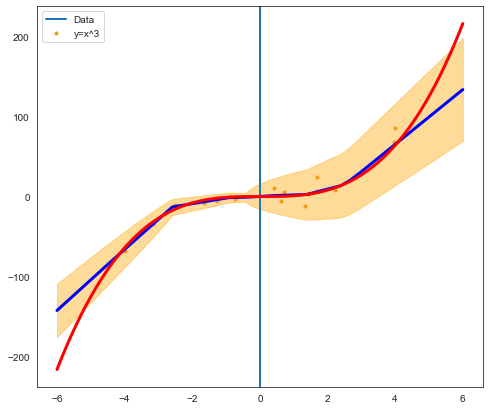

In [96]:
upper = [i + np.sqrt(k) * 3 for i, k in zip(means, variances)]
lower = [i - np.sqrt(k) * 3 for i, k in zip(means, variances)]

plt.rcParams['figure.figsize'] = [8, 7]
plt.axvline(x=0, linewidth=2)
plt.plot(data_x, data_y, '.', markersize=6, color='#F39C12')
plt.plot(data_x_true, means, linewidth=3, color='b')
plt.fill_between(data_x_true.flatten(), upper, lower, color="orange", alpha=0.4)
plt.plot(data_x_true, data_y_true, 'r', linewidth=3)
plt.legend(['Data', 'y=x^3'], loc = 'best')
plt.show()

In [97]:
models = []
import random
import pytorch_lightning as pl

for i in range(5):
    seed = random.randint(0, 9999)
    print(i, seed)
    pl.seed_everything(seed)
    mlp = GaussianMLP()
    trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=500)
    dataloader = DataLoader(toy_dataset, num_workers=1, batch_size=1, shuffle=True)
    trainer.fit(mlp, dataloader)
    models.append(mlp)

Global seed set to 418
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                         | Params
-------------------------------------------------------
0 | model | GaussianMultiLayerPerceptron | 402   
-------------------------------------------------------
402       Trainable params
0         Non-trainable params
402       Total params
0.002     Total estimated model params size (MB)


0 418


/home/cam/Documents/Git/pytorch-deep-ensembles/env/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/home/cam/Documents/Git/pytorch-deep-ensembles/env/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

Global seed set to 5285
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                         | Params
-------------------------------------------------------
0 | model | GaussianMultiLayerPerceptron | 402   
-------------------------------------------------------
402       Trainable params
0         Non-trainable params
402       Total params
0.002     Total estimated model params size (MB)


1 5285


Training: 0it [00:00, ?it/s]

Global seed set to 379
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                         | Params
-------------------------------------------------------
0 | model | GaussianMultiLayerPerceptron | 402   
-------------------------------------------------------
402       Trainable params
0         Non-trainable params
402       Total params
0.002     Total estimated model params size (MB)


2 379


Training: 0it [00:00, ?it/s]

Global seed set to 511
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                         | Params
-------------------------------------------------------
0 | model | GaussianMultiLayerPerceptron | 402   
-------------------------------------------------------
402       Trainable params
0         Non-trainable params
402       Total params
0.002     Total estimated model params size (MB)


3 511


Training: 0it [00:00, ?it/s]

Global seed set to 1777
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                         | Params
-------------------------------------------------------
0 | model | GaussianMultiLayerPerceptron | 402   
-------------------------------------------------------
402       Trainable params
0         Non-trainable params
402       Total params
0.002     Total estimated model params size (MB)


4 1777


Training: 0it [00:00, ?it/s]

In [98]:
import numpy as np
means = []
variances = []

for model in models:
    model.eval()
    preds = []
    sigmas = []

    for x in data_x_true:
        mu, sigma = model(torch.Tensor(x).unsqueeze(0))
        preds.append(mu.item())
        sigmas.append(sigma.item())
    
    means.append(preds)
    variances.append(sigmas)
means = torch.tensor(means)
variances = torch.tensor(variances)

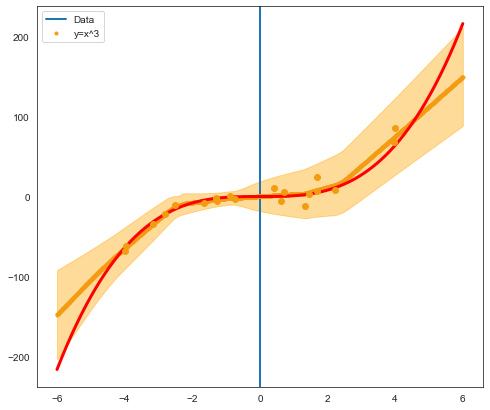

In [99]:
import numpy as np

mean = means.mean(0)
variance = (variances +  means.pow(2)).mean(0) - mean.pow(2)

std_devs = np.sqrt(variance.numpy()) * 3

upper = [i + k for i, k in zip(mean.numpy(), std_devs)]
lower = [i - k for i, k in zip(mean.numpy(), std_devs)]

plt.rcParams['figure.figsize'] = [8, 7]
plt.axvline(x=0, linewidth=2)
plt.plot(data_x_true, mean, '.', markersize=6, color='#F39C12')
plt.fill_between(data_x_true.flatten(), upper, lower, color="orange", alpha=0.4)
plt.plot(data_x_true, data_y_true, 'r', linewidth=3)
plt.plot(data_x, data_y, '.', markersize=12, color='#F39C12')
plt.legend(['Data', 'y=x^3'], loc = 'best')
plt.show()

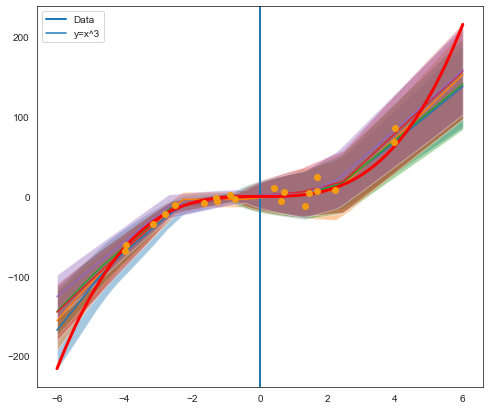

In [100]:
import numpy as np

mean = means.mean(0)
variance = (variances +  means.pow(2)).mean(0) - mean.pow(2)

std_devs = np.sqrt(variance.numpy()) * 3 / 2 

upper = [i + k for i, k in zip(mean.numpy(), std_devs)]
lower = [i - k for i, k in zip(mean.numpy(), std_devs)]

plt.rcParams['figure.figsize'] = [8, 7]
plt.axvline(x=0, linewidth=2)
for (mean, variance) in zip(means, variances):
    std = np.sqrt(variance.numpy()) * 3
    upper = [i + k for i, k in zip(mean.numpy(), std)]
    lower = [i - k for i, k in zip(mean.numpy(), std)]
    plt.fill_between(data_x_true.flatten(), upper, lower, alpha=0.4)
    plt.plot(data_x_true, mean)
plt.plot(data_x_true, data_y_true, 'r', linewidth=3)
plt.plot(data_x, data_y, '.', markersize=12, color='#F39C12')
plt.legend(['Data', 'y=x^3'], loc = 'best')
plt.show()